In [1]:
# Import Packages and setup
import logging

import numpy as np
from astropy.io import fits

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
images = fits.open("/users/fred/Downloads/multi_band_im.fits")[0].data.byteswap().newbyteorder()

In [3]:
import sep
def makeCatalog(img):
    detect = img.mean(axis=0) # simple average for detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 1.5, err=bkg.globalrms)
    bg_rms = np.array([sep.Background(band).globalrms for band in img])
    return catalog, bg_rms

catalog, bg_rms = makeCatalog(images)

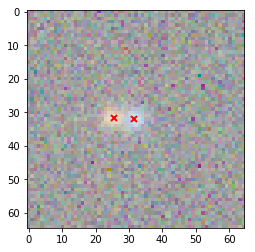

In [4]:
# Use Asinh scaling for the images
norm = scarlet.display.Asinh(img=images, Q=20)
# Map i,r,g -> RGB
filter_indices = [2,1,0]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    plt.plot(src["x"], src["y"], "rx", mew=2)
plt.show()

In [5]:
coords = [(src["y"], src["x"]) for src in catalog]
im = images
bg = [10] * len(im)

In [6]:
def run_step(blend, e_rel=1e-20, steps=1):
    _seds = np.array([component.sed for component in blend.components])
    _morphs = [component.morph for component in blend.components]
    blend.fit(steps, e_rel=e_rel)
    seds = np.array([component.sed for component in blend.components])
    morphs = [component.morph for component in blend.components]
    dS = np.sum((seds-_seds)**2, axis=1)
    dM = np.array([np.sum((m0-m1)**2) for m0, m1 in zip(morphs, _morphs)])
    return dS, dM

def run_scarlet(blend, it, steps=1, refine_skip=10):
    all_dS = []
    all_dM = []
    iterations = []
    for i in range(int(np.ceil(it/steps))):
        dS, dM = run_step(blend, steps=steps)
        all_dS.append(dS)
        all_dM.append(dM)
        iterations.append(blend.it)
    all_dS = np.array(all_dS)
    all_dM = np.array(all_dM)
    print(blend.it, "iterations")
    print("source sizes:", blend.config.source_sizes)

    plt.plot(iterations, all_dS[:,0], label="Source 0")
    plt.plot(iterations, all_dS[:,1], label="Source 1")
    plt.title("SED")
    plt.xlabel("Iteration")
    plt.ylabel("$\chi^2$")
    plt.legend()
    plt.show()

    plt.semilogy(iterations, all_dM[:,0], label="Source 0")
    plt.semilogy(iterations, all_dM[:,1], label="Source 1")
    plt.title("morphology")
    plt.xlabel("Iteration")
    plt.ylabel("$\chi^2$")
    plt.legend()
    plt.show()

def display_model(blend):
    # Load the model and calculate the residual
    model = blend.get_model()
    residual = images-model
    # Create RGB images
    model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
    residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)

    # Show the data, model, and residual
    fig = plt.figure(figsize=(15,5))
    ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    ax[1].imshow(model_rgb)
    ax[1].set_title("Model")
    ax[2].imshow(residual_rgb)
    ax[2].set_title("Residual")

    for k,component in enumerate(blend.components):
        y,x = component.center
        ax[0].text(x, y, k, color="b")
        ax[1].text(x, y, k, color="b")
    plt.show()

def get_true_image(m, catalog, filters):
    """Create the true multiband image for a source
    """
    img = np.array([catalog[m]["intensity_"+f] for f in filters])
    return img

filters = ["B", "G", "R"]

def display_templates(blend):
    has_truth = False
    axes = 2

    for k,src in enumerate(blend.components):
        # Get the model for a single source
        model = blend.get_model(k=k)[src.bb]
        _rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
        # Get the patch from the original image
        _img = images[src.bb]
        _img_rgb = scarlet.display.img_to_rgb(_img, filter_indices=filter_indices, norm=norm)
        # Set the figure size
        ratio = src.shape[2]/src.shape[1]
        fig_height = 3*src.shape[1]/20
        fig_width = max(3*fig_height*ratio,2)
        fig = plt.figure(figsize=(fig_width, fig_height))
        # Generate and show the figure
        ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
        ax[0].imshow(_img_rgb)
        ax[0].set_title("Data")
        ax[1].imshow(_rgb)
        ax[1].set_title("model {0}".format(k))
        if has_truth:
            # Get the true image for the same source
            truth = get_true_image(k, catalog, filters)[src.bb]
            true_rgb = scarlet.display.img_to_rgb(truth, filter_indices=filter_indices, norm=norm)
            ax[2].imshow(true_rgb)
            mask = np.sum(truth, axis=0) > 0
            mask = np.ma.array(~mask, mask=mask)
            plt.imshow(mask)
            ax[2].set_title("truth")
        plt.show()

In [7]:
import logging
logger = logging.getLogger("proxmin")
logger.setLevel(logging.ERROR)

800 iterations
source sizes: [ 15  25  45  75 115 165]


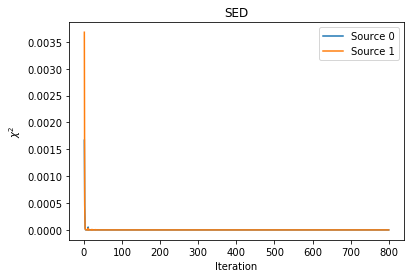

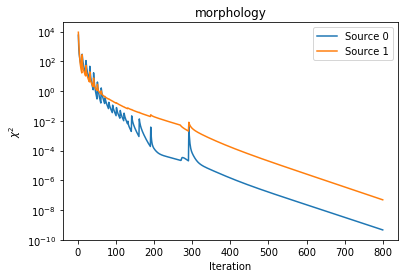

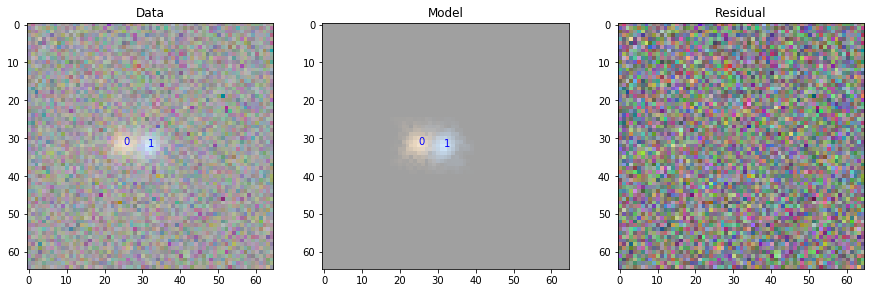

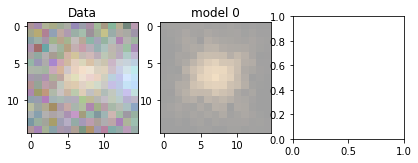

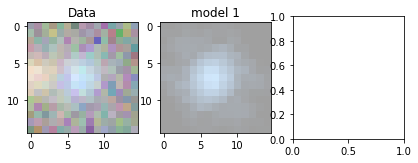

In [8]:
sources = [scarlet.ExtendedSource(coord, im, bg_rms = bg,
           psf=None) for coord in coords]
blend0 = scarlet.Blend(sources)
blend0.set_data(images, bg_rms=bg_rms)
run_scarlet(blend0, 800)
display_model(blend0)
display_templates(blend0)

800 iterations
source sizes: [51]


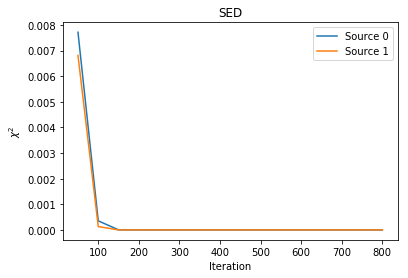

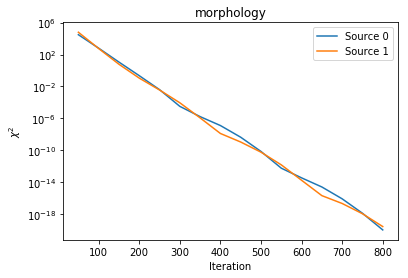

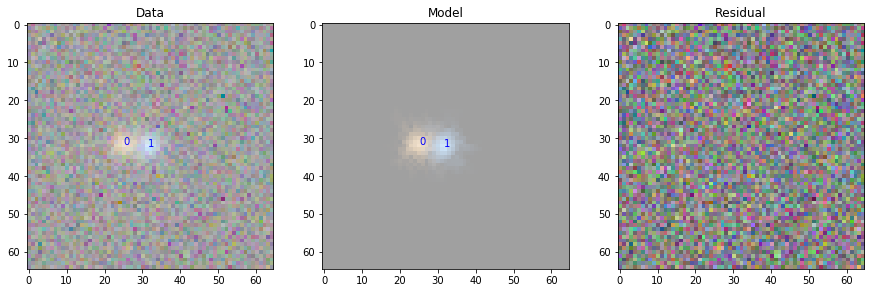

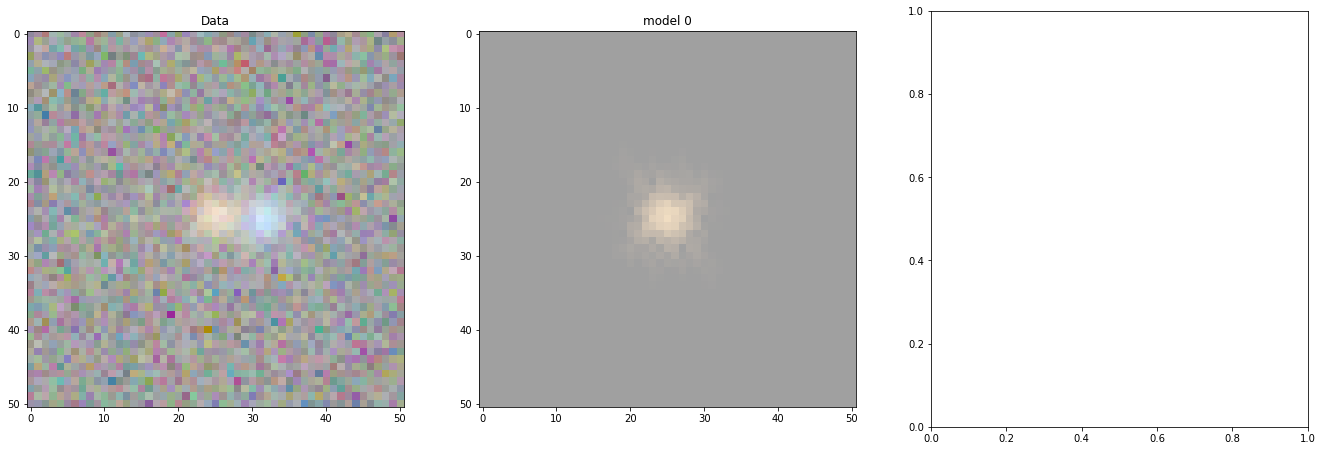

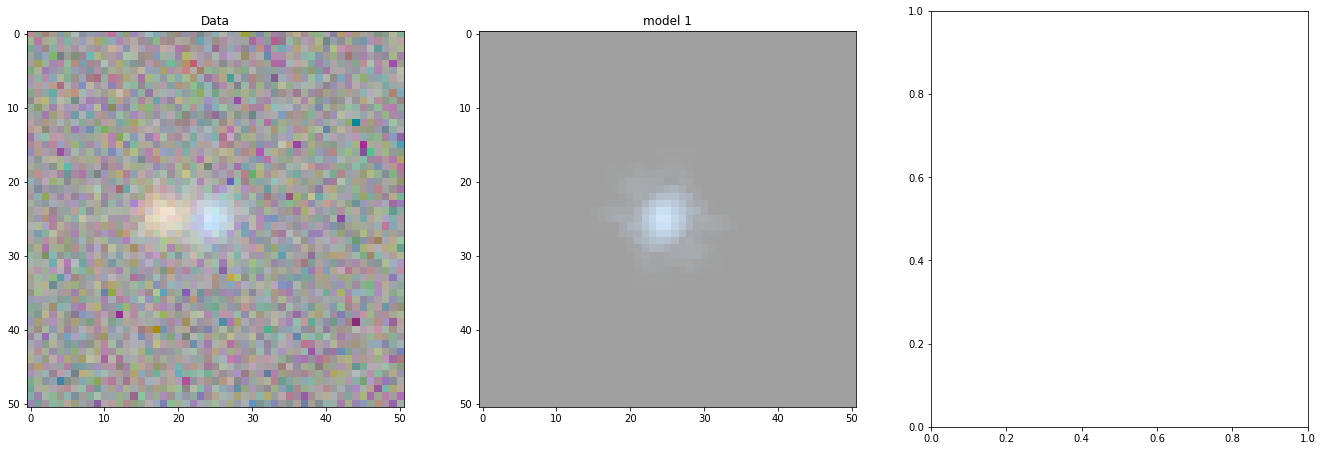

In [20]:
config = scarlet.Config(source_sizes=[50])
sources = [scarlet.ExtendedSource(coord, im, bg_rms = bg,
           psf=None,config=config) for coord in coords]
blend1 = scarlet.Blend(sources)
blend1.set_data(im, bg_rms = bg,config=config)
run_scarlet(blend1, 800, steps=50)
display_model(blend1)
display_templates(blend1)

800 iterations
source sizes: [51]


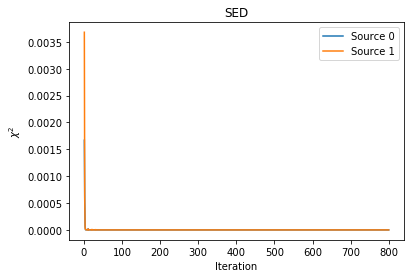

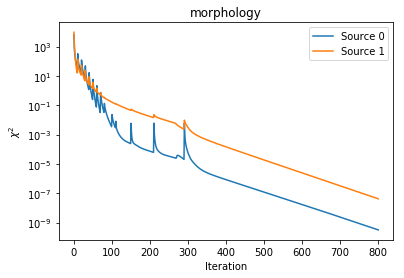

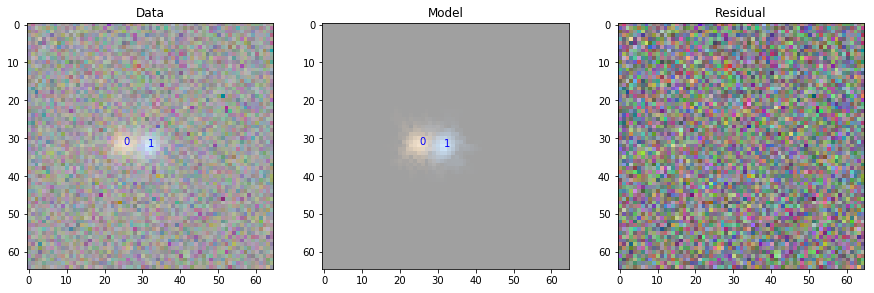

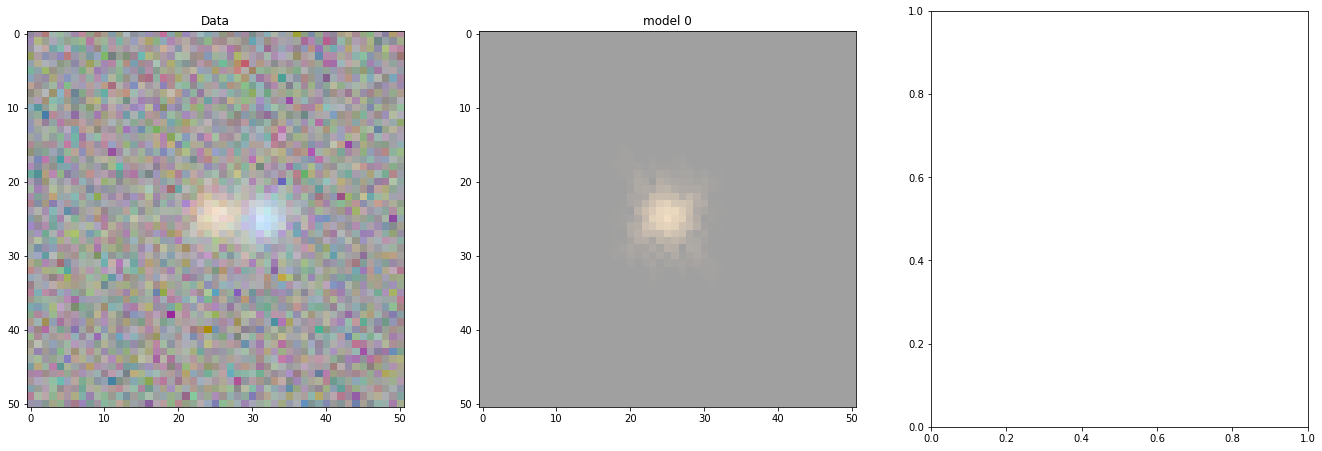

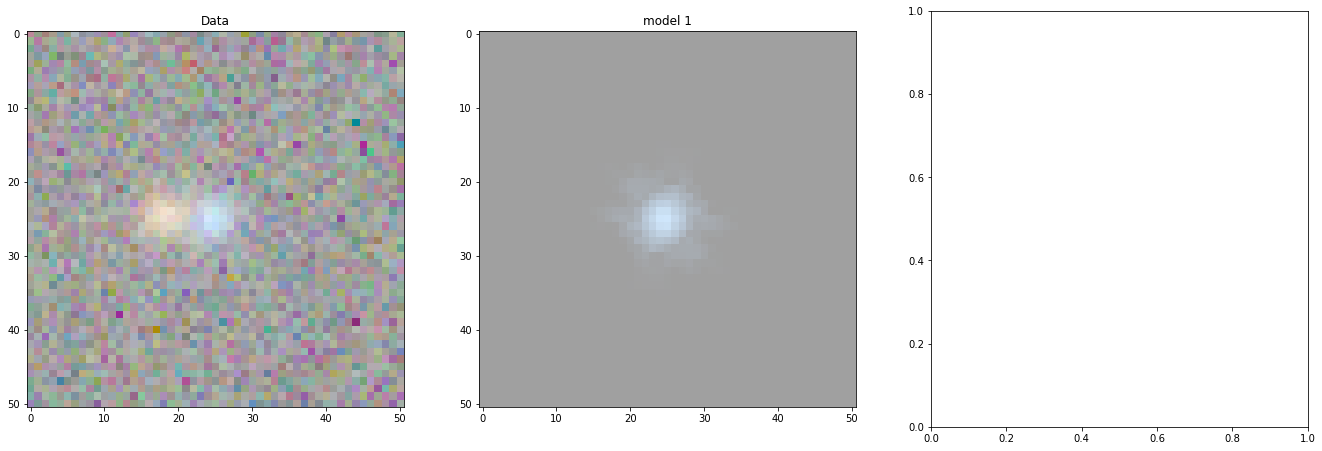

In [9]:
config = scarlet.Config(source_sizes=[50])
sources = [scarlet.ExtendedSource(coord, im, bg_rms = bg,
           psf=None,config=config) for coord in coords]
blend1 = scarlet.Blend(sources)
blend1.set_data(im, bg_rms = bg,config=config)
run_scarlet(blend1, 800)
display_model(blend1)
display_templates(blend1)

800 iterations
source sizes: [51]


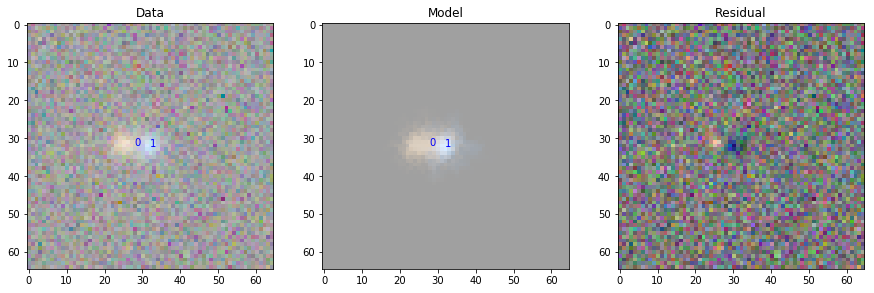

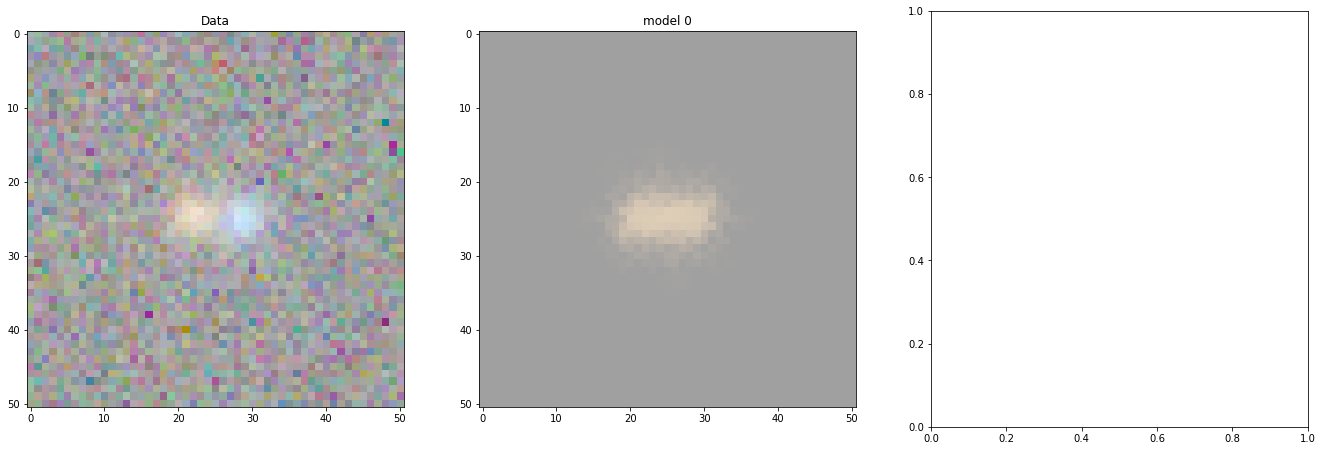

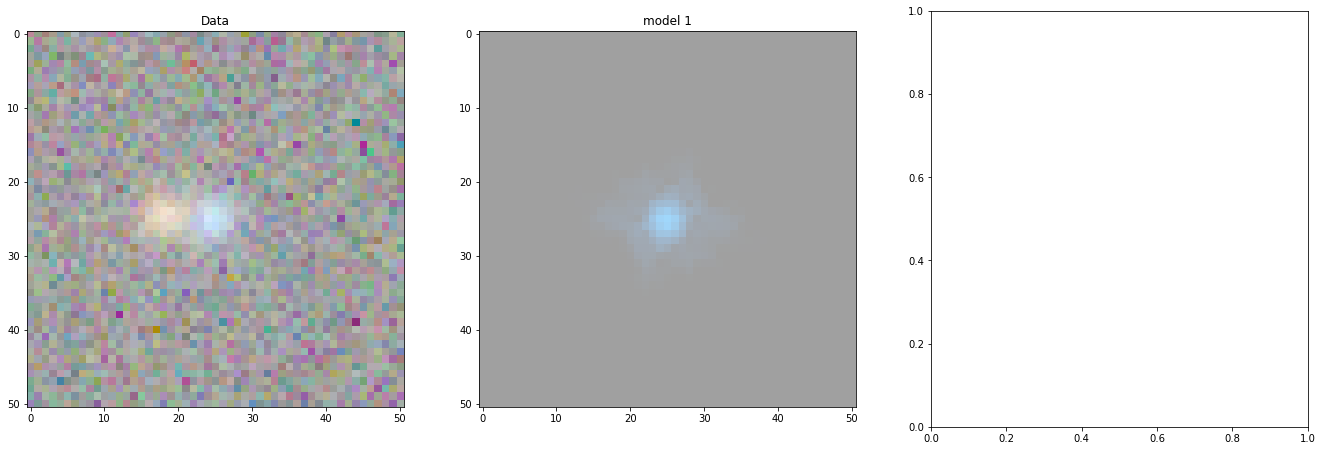

In [10]:
from proxmin.utils import Traceback

traceback = Traceback(N=4)

config = scarlet.Config(source_sizes=[50], traceback=traceback)
sources = [scarlet.ExtendedSource(coord, im, bg_rms = bg,
                psf=None,config=config) for coord in coords]
blend2 = scarlet.Blend(sources)
blend2.set_data(im, bg_rms = bg,config=config)
# Dies at 3286 (so don't run past 3285)
blend2.fit(800, e_rel=1e-3)

print(blend2.it, "iterations")
print("source sizes:", blend2.config.source_sizes)
display_model(blend2)
display_templates(blend2)

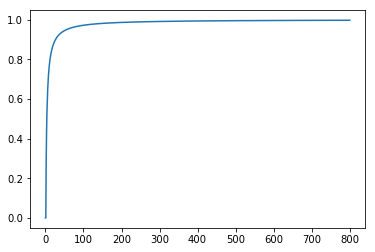

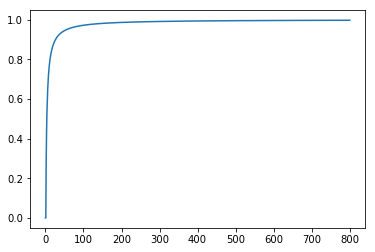

In [20]:
plt.plot(traceback.history[0]["omega"][0])
plt.show()
plt.plot(traceback.history[1]["omega"][0])
plt.show()

DEBUG:scarlet.blend:shifting component (0, 0) by (0.028/-0.162) to (31.669/25.283) in it 10
DEBUG:scarlet.blend:shifting component (1, 0) by (0.065/0.111) to (32.077/31.498) in it 10
DEBUG:scarlet.blend:shifting component (0, 0) by (0.006/-0.129) to (31.675/25.154) in it 20
DEBUG:scarlet.blend:shifting component (1, 0) by (0.017/0.034) to (32.094/31.532) in it 20
DEBUG:scarlet.blend:shifting component (0, 0) by (-0.015/-0.063) to (31.660/25.091) in it 30
DEBUG:scarlet.blend:shifting component (1, 0) by (0.006/0.007) to (32.101/31.538) in it 30
DEBUG:scarlet.blend:shifting component (0, 0) by (0.009/-0.046) to (31.669/25.045) in it 40
DEBUG:scarlet.blend:shifting component (1, 0) by (0.004/0.003) to (32.105/31.541) in it 40
DEBUG:scarlet.blend:shifting component (0, 0) by (-0.012/-0.038) to (31.657/25.007) in it 50
DEBUG:scarlet.blend:shifting component (1, 0) by (-0.004/-0.007) to (32.101/31.534) in it 50
DEBUG:scarlet.blend:shifting component (0, 0) by (-0.006/-0.024) to (31.651/24.98

Total iterations 280


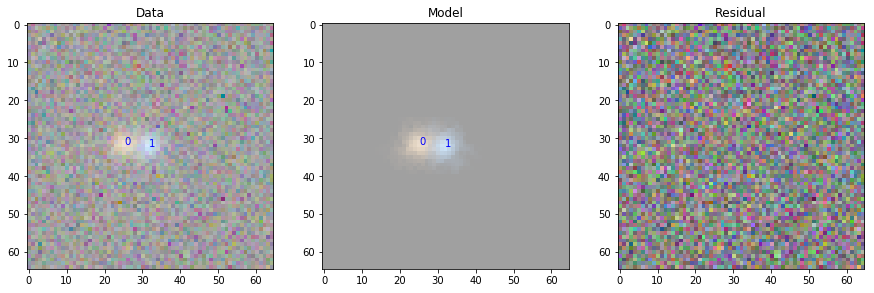

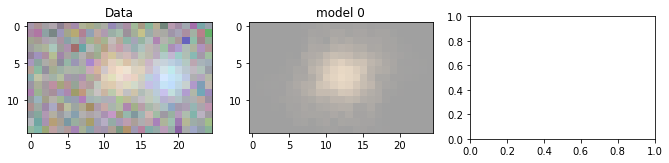

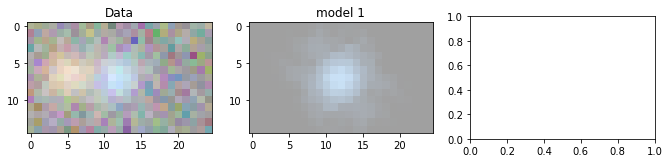

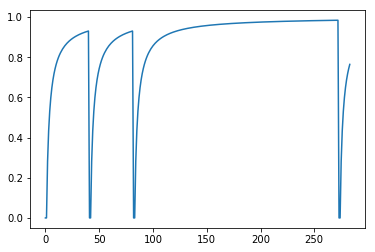

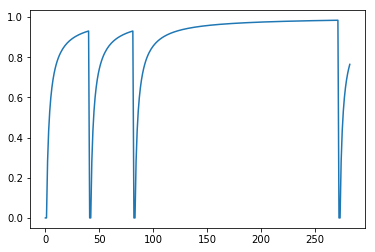

In [28]:
logger = logging.getLogger("scarlet.blend")
logger.setLevel(logging.DEBUG)


traceback = Traceback(N=4)

config = scarlet.Config(traceback=traceback)
sources = [scarlet.ExtendedSource(coord, im, bg_rms = bg,
           psf=None,config=config) for coord in coords]
blend1 = scarlet.Blend(sources)
blend1.set_data(im, bg_rms = bg,config=config)
blend1.fit(40, e_rel=1e-20)
blend1.fit(40, e_rel=1e-20)
blend1.fit(200, e_rel=1e-20)
print("Total iterations", blend1.it)
display_model(blend1)
display_templates(blend1)

plt.plot(traceback.history[0]["omega"][0])
plt.show()
plt.plot(traceback.history[1]["omega"][0])
plt.show()